1. Write a report that examines the evolution of behavior on the cart pole task (or any other task). Successfully optimise the controller to achieve greater than 95% accuracy on the cart pole task model provided in the worksheet. You can use a GA, or a population of hillclimbers, or any other algorithm you wish to construct (but don't use an optimization package). 

Minimal required  technical achievements:

* Demonstrate that the controller is evolving with a plot of best fitness versus tournaments for several runs of your algorithm. 
* Demonstrate with plots the behavior of the successful controller, e.g., plot angle versus time, angular velocity versus time, or provide a link to a video.
* Show examples of the best controller after 0 tournaments, halfway through the run,  and at the end of optimization, and describe what changes in the behavior. 

You might consider choosing behaviors associated with jumps in fitness (GA’s often exhibit plateaus and then sudden jumps).

In [1]:
!apt-get update
!apt install xvfb 
!apt-get install x11-utils > /dev/null 2>&1
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

import os
import shutil
import copy
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
import numpy as np
import torch
from pyvirtualdisplay import Display

env_name = 'CartPole-v1'
env = gym.make(env_name)

display = Display(visible=0, size=(400, 300))
display.start()
prev_screen = env.render(mode='rgb_array')

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [748 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ P

In [2]:
class Agent:
    def __init__(self, num_input, num_output):
        self.num_input = num_input 
        self.num_output = num_output
        self.num_genes = num_input * num_output + num_output
        self.weights = None
        self.bias = None

    def set_genes(self, gene):
        weight_idxs = self.num_input * self.num_output
        bias_idxs = self.num_input * self.num_output + self.num_output
        w = gene[0 : weight_idxs].reshape(self.num_output, self.num_input)   
        b = gene[weight_idxs: bias_idxs].reshape(self.num_output,)
        self.weights = torch.from_numpy(w)
        self.bias = torch.from_numpy(b)

    def forward(self, x):
        x = torch.from_numpy(x).unsqueeze(0)
        return torch.mm(x, self.weights.T) + self.bias

    def get_action(self, x):
        if self.forward(x) > 0:
            return 1
        else:
            return 0

In [3]:
def run_episode(env, agent):
    tot_reward = 0.0
    observations = []
    obs = env.reset()
    observations.append(obs)
    done = False
    while not done:
        action = agent.get_action(obs)
        obs, reward, done, info = env.step(action)
        observations.append(obs)
        tot_reward = tot_reward + reward
    return observations, tot_reward

In [4]:
def save_vis(env, agent=None, dirname='sim_frames'):
    if os.path.isdir(dirname):
      shutil.rmtree(dirname)
    os.makedirs(dirname, exist_ok=True)
    tot_reward = 0.0
    obs = env.reset()
    done = False
    curr_t = 0
    while not done:
        if agent is not None:
            action = agent.get_action(obs)
        else:
            action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        screen = env.render(mode='rgb_array')
        tot_reward = tot_reward + reward
        plt.imshow(screen)
        plt.title(curr_t)
        plt.savefig(os.path.join(dirname, 'fig{}'.format(curr_t)))
        curr_t += 1

In [5]:
def fitness_function(env, agent, gene_pop):
    # Get fitness for each gene
    pop_size = gene_pop.shape[0]
    pop_fitness = np.zeros(pop_size)
    for i, gene in enumerate(gene_pop):
        agent.set_genes(gene)
        pop_fitness[i] = run_episode(env, agent)[1]
    return pop_fitness

In [6]:
def mutation_function(gene_pop, mean=0, std=0.1):
    gene_pop = np.copy(gene_pop)
    for i, gene in enumerate(gene_pop):
        gene_pop[i] = gene_pop[i] + np.random.normal(mean, std, size=gene.shape)
    # constraint
    gene_pop[gene_pop > 3] = 3
    gene_pop[gene_pop < -3] = -3
    return gene_pop

In [7]:
def select_genes(prev_gene_pop, gene_pop, prev_fitness, fitness):
    new_gene_pop = np.zeros_like(gene_pop)
    for i, gene in enumerate(gene_pop): 
        if fitness[i] >= prev_fitness[i]: 
            new_gene_pop[i] = gene_pop[i]
        else:
            new_gene_pop[i] = prev_gene_pop[i]
    return new_gene_pop

In [8]:
def get_best_gene(gene_pop, fitness):
    i = np.argmax(fitness)
    return gene_pop[i]

In [9]:
def ga(generations, pop_size, mutation_mean, mutation_std, num_obs, num_actions):
    agent = Agent(num_obs, num_actions)
    # Create the gene population
    gene_pop = np.zeros((pop_size, agent.num_genes))
    # Get initial fitness of the population
    fitness = fitness_function(env, agent, gene_pop)
    prev_fitness = fitness
    prev_gene_pop = gene_pop
    # Main loop
    max_fitness_over_generations = []
    for generation in range(generations):
        # Mutate the population
        gene_pop = mutation_function(prev_gene_pop, mutation_mean, mutation_std)
        # Get fitness of the mutated population
        fitness = fitness_function(env, agent, gene_pop)
        # Apply selection 
        gene_pop = select_genes(prev_gene_pop, gene_pop, prev_fitness, fitness)
        # Evaluate the fitness of the selected population
        prev_fitness = fitness_function(env, agent, gene_pop)
        prev_gene_pop = gene_pop
        # Values used for plots
        max_fitness_over_generations.append(max(prev_fitness))
        if generation == 0: 
            best_gene_start = get_best_gene(prev_gene_pop, prev_fitness)
        if generation == generations // 2:
            best_gene_midway = get_best_gene(prev_gene_pop, prev_fitness)
    return gene_pop, fitness, max_fitness_over_generations, best_gene_start, best_gene_midway

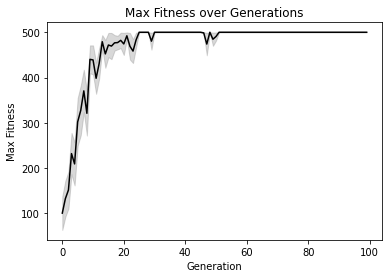

In [10]:
generations = 100
pop_size = 15
mutation_mean = 0
mutation_std = 0.1
num_obs = 4
num_actions = 1

trials = 10
agent = Agent(4, 1)

max_fitnesses = []
for trial in range(trials):
    max_fitnesses.append(ga(generations, pop_size, mutation_mean, mutation_std, 
                            num_obs, num_actions)[2])
max_fitnesses_means = np.empty(generations)
max_fitnesses_stds = np.empty(generations)
for g in range(generations):
    max_fitnesses_curr_g = [max_fitnesses_trial[g] for max_fitnesses_trial in max_fitnesses]
    max_fitnesses_means[g] = np.mean(max_fitnesses_curr_g)
    max_fitnesses_stds[g] = np.std(max_fitnesses_curr_g) / np.sqrt(len(max_fitnesses_curr_g))
plt.plot(max_fitnesses_means, c='black')
plt.fill_between(range(generations), max_fitnesses_means - max_fitnesses_stds, 
                 max_fitnesses_means + max_fitnesses_stds, color='gray', alpha=.3)
plt.xlabel('Generation')
plt.ylabel('Max Fitness')
plt.title(f'Max Fitness over Generations')
plt.show()

In [11]:
def plot_cartpole_observations(gene):
    agent = Agent(4, 1)
    agent.set_genes(gene)

    observations = run_episode(env, agent)[0]
    num_observations = len(observations)
    cart_pos = np.empty(num_observations)
    cart_velocity = np.empty(num_observations)
    pole_angle = np.empty(num_observations)
    pole_rotation_rate = np.empty(num_observations)

    for i, obs in enumerate(observations):
        cart_pos[i] = obs[0]
        cart_velocity[i] = obs[1]
        pole_angle[i] = obs[2]
        pole_rotation_rate[i] = obs[3]

    name_switcher = {
        0 : 'Position of Cart',
        1 : 'Velocity of Cart',
        2 : 'Angle of Pole',
        3 : 'Rotation Rate of Pole'
    }

    obs_types = [cart_pos, cart_velocity, pole_angle, pole_rotation_rate]
    for obs_index, obs_type in enumerate(obs_types):
        plt.plot(range(num_observations), obs_type, c='black')
        plt.xlabel('Time')
        plt.ylabel(name_switcher.get(obs_index))
        plt.title(f'{name_switcher.get(obs_index)} over Time')
        plt.show()

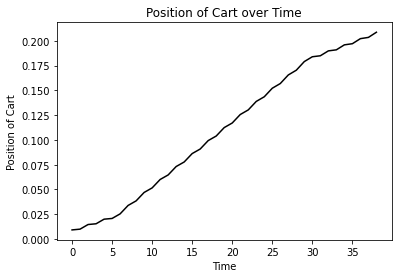

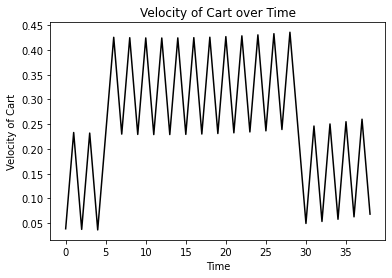

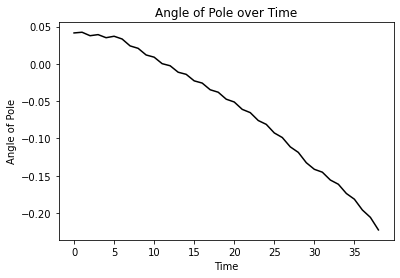

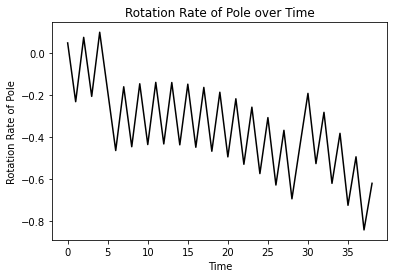

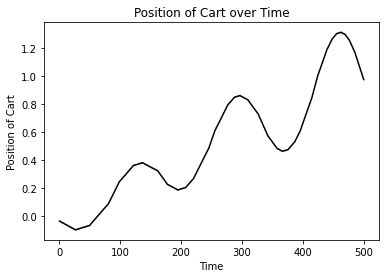

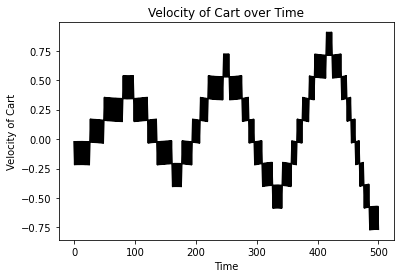

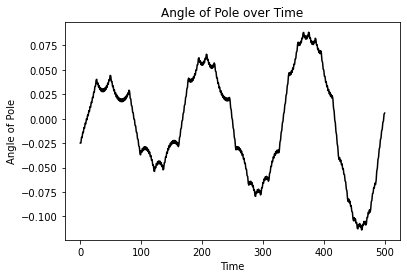

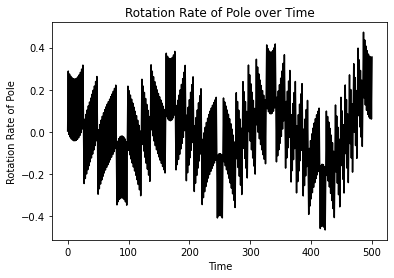

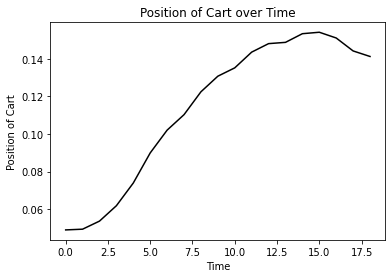

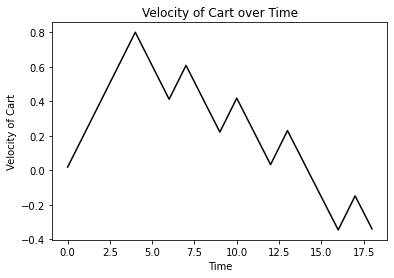

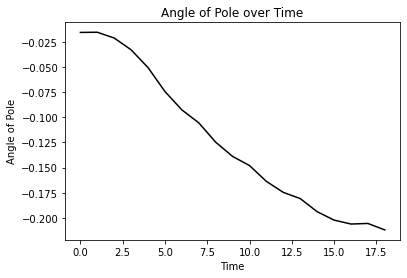

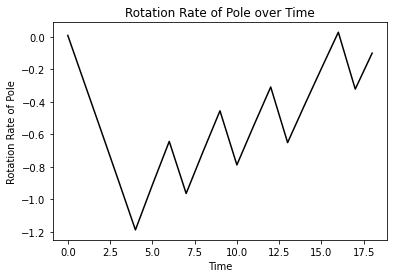

In [12]:
generations = 100
pop_size = 15
mutation_mean = 0
mutation_std = 0.1
num_obs = 4
num_actions = 1

gene_pop, fitness, _, best_gene_start, best_gene_midway = ga(generations, pop_size, 
                                                  mutation_mean, mutation_std, 
                                                  num_obs, num_actions)
best_gene = get_best_gene(gene_pop, fitness)

plot_cartpole_observations(best_gene_start)
plot_cartpole_observations(best_gene_midway)
plot_cartpole_observations(best_gene)

In [13]:
print(best_gene_start, best_gene_midway, best_gene)

[ 0.11758117 -0.06551989 -0.03756131  0.14110751  0.04404308] [-8.22943804e-04  2.34013163e-01  1.60110907e-01  8.38990585e-01
 -2.30004934e-02] [0.16990124 0.27449537 0.38616047 0.34041794 0.14203865]


Best Gene Start: [-0.13816018, -0.17759338, 0.14634308, 0.13717168, 0.00366755]

Best Gene Midway: [0.11105069, 0.31322729, 0.60160967, 0.47562479, -0.19621205]

Best Gene End: [0.41765513, 0.32247807, 1.26364312, 0.39733671, 0.17534011]

In [14]:
best_gene_start = [-0.13816018, -0.17759338, 0.14634308, 0.13717168, 0.00366755]
best_gene_midway = [0.11105069, 0.31322729, 0.60160967, 0.47562479, -0.19621205]
best_gene = [0.41765513, 0.32247807, 1.26364312, 0.39733671, 0.17534011]

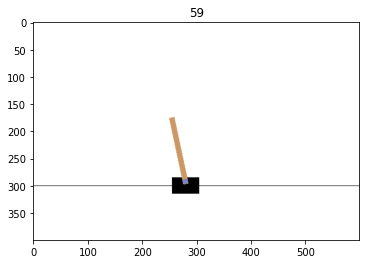

In [15]:
agent = Agent(4, 1)
# Using best gene at the start
agent.set_genes(np.array(best_gene_start))
save_vis(env, agent)

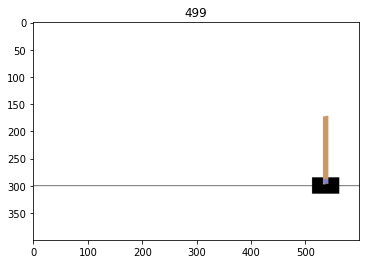

In [ ]:
agent = Agent(4, 1)
# Using best gene halfway through GA
agent.set_genes(np.array(best_gene_midway))
save_vis(env, agent)

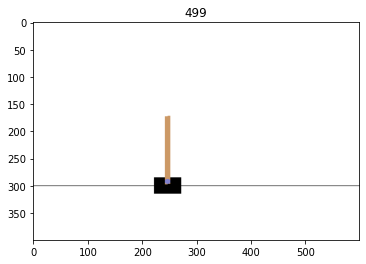

In [ ]:
agent = Agent(4, 1)
# Using best gene at the end
agent.set_genes(np.array(best_gene))
save_vis(env, agent)

In [ ]:
# save sim_frames folder locally
!zip -r /content/sim_frames.zip /content/sim_frames
from google.colab import files
files.download("/content/sim_frames.zip")

  adding: content/sim_frames/ (stored 0%)
  adding: content/sim_frames/fig375.png (deflated 16%)
  adding: content/sim_frames/fig77.png (deflated 16%)
  adding: content/sim_frames/fig126.png (deflated 17%)
  adding: content/sim_frames/fig312.png (deflated 16%)
  adding: content/sim_frames/fig170.png (deflated 18%)
  adding: content/sim_frames/fig57.png (deflated 15%)
  adding: content/sim_frames/fig16.png (deflated 15%)
  adding: content/sim_frames/fig493.png (deflated 17%)
  adding: content/sim_frames/fig485.png (deflated 17%)
  adding: content/sim_frames/fig499.png (deflated 17%)
  adding: content/sim_frames/fig64.png (deflated 15%)
  adding: content/sim_frames/fig405.png (deflated 17%)
  adding: content/sim_frames/fig98.png (deflated 17%)
  adding: content/sim_frames/fig34.png (deflated 17%)
  adding: content/sim_frames/fig486.png (deflated 16%)
  adding: content/sim_frames/fig17.png (deflated 14%)
  adding: content/sim_frames/fig86.png (deflated 17%)
  adding: content/sim_frames/fi

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def controller_accuracy(genotype):
    agent = Agent(4, 1)
    agent.set_genes(np.array(genotype))
    succesful_episodes = 0
    for i in range(10000):
        if run_episode(env, agent)[1] == 500:
            succesful_episodes += 1
    return succesful_episodes/10000

In [ ]:
# Using best gene at the start
print(f"The best controller's accuracy at the start is {controller_accuracy(best_gene_start)}")
# Using best gene halfway through GA
print(f"The best controller's accuracy halfway through GA is {controller_accuracy(best_gene_midway)}")
# Using best gene at the end
print(f"The best controller's accuracy at the end is {controller_accuracy(best_gene)}")

The best controller's accuracy at the start is 0.0044
The best controller's accuracy halfway through GA is 0.9992
The best controller's accuracy at the end is 1.0


The best controller's accuracy at the start is 0.0048

The best controller's accuracy halfway through GA is 0.9993

The best controller's accuracy at the end is 1.0